In [ ]:
# 📌 Install dependencies
!pip install gymnasium[classic_control] matplotlib numpy torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 819.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

In [ ]:
# Create the CartPole-v1 environment
env = gym.make("CartPole-v1")
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


In [ ]:
# Discretization Function for Q-Table
NUM_BINS = 40
BINS = [
    np.linspace(-4.8, 4.8, NUM_BINS),
    np.linspace(-5, 5, NUM_BINS),
    np.linspace(-0.418, 0.418, NUM_BINS),
    np.linspace(-5, 5, NUM_BINS)
]

def discretize_state(state):
    return tuple(np.digitize(state[i], BINS[i]) - 1 for i in range(len(state)))

In [ ]:
# Epsilon-Greedy Policy
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])
    return np.argmax(Q[state])

In [ ]:
# TD(0) Algorithm
def td_zero(env, episodes=2000, alpha=0.3, gamma=0.9, epsilon=0.3, decay_rate=0.997):
    Q = np.zeros((NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n))
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state)
        total_reward = 0

        while True:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize_state(next_state)
            total_reward += reward

            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state
            if terminated or truncated:
                break

        rewards.append(total_reward)
        epsilon = max(0.01, epsilon * decay_rate)  # Apply decay
    return rewards

In [ ]:
# SARSA Algorithm
def sarsa(env, episodes=2000, alpha=0.3, gamma=0.9, epsilon=0.3, decay_rate=0.997):
    Q = np.zeros((NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n))
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state)
        action = epsilon_greedy(Q, state, epsilon)
        total_reward = 0

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize_state(next_state)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            total_reward += reward

            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action
            if terminated or truncated:
                break

        rewards.append(total_reward)
        epsilon = max(0.01, epsilon * decay_rate)  # Apply decay
    return rewards


In [ ]:
# Q-Learning Algorithm
def q_learning(env, episodes=2000, alpha=0.3, gamma=0.9, epsilon=0.3, decay_rate=0.997):
    Q = np.zeros((NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n))
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state)
        total_reward = 0

        while True:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize_state(next_state)
            total_reward += reward

            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state
            if terminated or truncated:
                break

        rewards.append(total_reward)
        epsilon = max(0.01, epsilon * decay_rate)  # Apply decay
    return rewards

In [ ]:
# Define the DQN Network
# class DQN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         return self.fc3(x)

# # DQN Learning with Experience Replay
# def dqn_learning(env, episodes=2000, gamma=0.9, lr=0.001, batch_size=64, epsilon=0.3, decay_rate=0.997):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     input_dim = env.observation_space.shape[0]
#     output_dim = env.action_space.n

#     policy_net = DQN(input_dim, output_dim).to(device)
#     target_net = DQN(input_dim, output_dim).to(device)
#     target_net.load_state_dict(policy_net.state_dict())
#     target_net.eval()

#     optimizer = optim.Adam(policy_net.parameters(), lr=lr)
#     loss_fn = nn.SmoothL1Loss()
#     memory = deque(maxlen=2000)
#     rewards = []
#     update_step = 0

#     for episode in range(episodes):
#         state, _ = env.reset()
#         total_reward = 0

#         while True:
#             action = env.action_space.sample() if np.random.rand() < epsilon else torch.argmax(policy_net(torch.FloatTensor(state).to(device))).item()
#             next_state, reward, terminated, truncated, _ = env.step(action)
#             memory.append((state, action, reward, next_state, terminated or truncated))
#             state = next_state
#             total_reward += reward
#             if terminated or truncated:
#                 break
#             update_step += 1
#             if update_step % 100 == 0:
#                 target_net.load_state_dict(policy_net.state_dict())

#         rewards.append(total_reward)
#         epsilon = max(0.01, epsilon * decay_rate)  # Apply decay

#     return rewards



In [ ]:
# Define the DQN Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Optimized DQN Algorithm
def dqn_learning(env, episodes=2000, gamma=0.9, lr=0.001, batch_size=64, epsilon=0.3, min_epsilon=0.01, decay_rate=0.997):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    loss_fn = nn.SmoothL1Loss()  # Use Huber Loss

    memory = deque(maxlen=2000)
    rewards = []

    def select_action(state, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Ensure batch dim
        with torch.no_grad():
            return torch.argmax(policy_net(state_tensor)).item()

    def replay():
        if len(memory) < batch_size:
            return
        batch = random.sample(memory, batch_size)
        states, actions, rewards_batch, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards_batch = torch.FloatTensor(rewards_batch).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Use Double DQN to reduce overestimation bias
        next_q_values = target_net(next_states).gather(1, policy_net(next_states).argmax(1, keepdim=True)).squeeze(1).detach()

        targets = rewards_batch + gamma * next_q_values * (1 - dones.float())

        loss = loss_fn(q_values, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        while True:
            action = select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            replay()
            if done:
                break

        rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return rewards



In [ ]:
# Rolling Average Function
def smooth(data, window_size=50):
    """Apply a rolling average to smooth learning curves."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



# Run and plot
td_rewards = td_zero(env)
sarsa_rewards = sarsa(env)
q_rewards = q_learning(env)
dqn_rewards = dqn_learning(env)



<ipython-input-57-3aedaa9a71a0>:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(device)


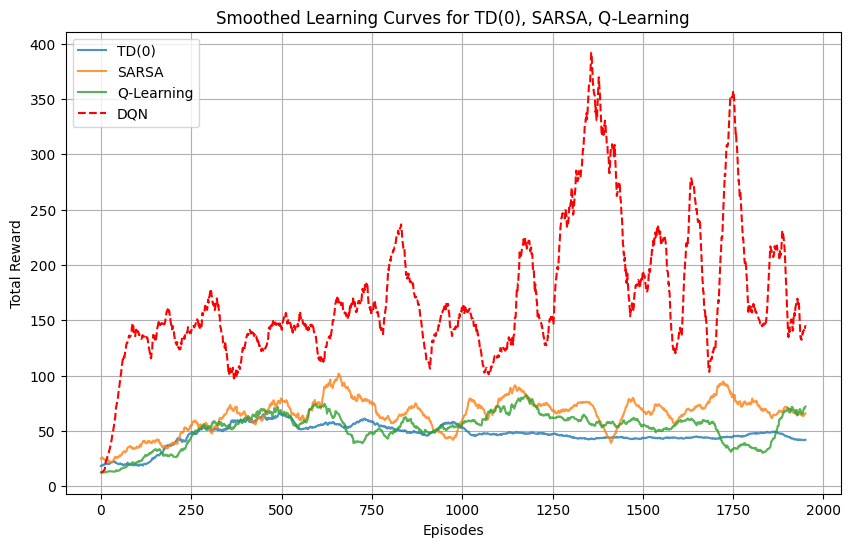

In [ ]:
# Improved Plot Function
def plot_learning_curves(td_rewards, sarsa_rewards, q_rewards):
    plt.figure(figsize=(10, 6))

    # Apply smoothing
    plt.plot(smooth(td_rewards), label="TD(0)", alpha=0.8)
    plt.plot(smooth(sarsa_rewards), label="SARSA", alpha=0.8)
    plt.plot(smooth(q_rewards), label="Q-Learning", alpha=0.8)
    plt.plot(smooth(dqn_rewards), label="DQN", linestyle="dashed", color="red")  # DQN in red dashed line
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Smoothed Learning Curves for TD(0), SARSA, Q-Learning")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(td_rewards, sarsa_rewards, q_rewards)

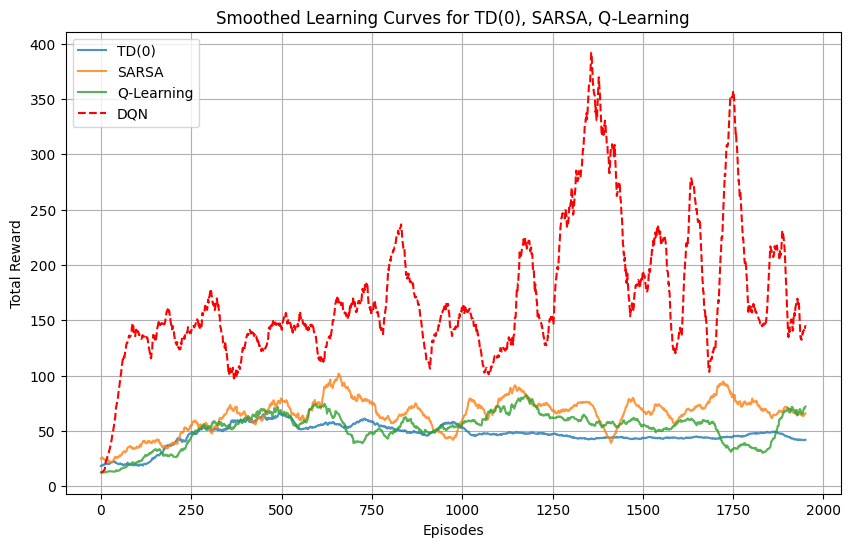

In [61]:
# Improved Plot Function
def plot_learning_curves(td_rewards, sarsa_rewards, q_rewards, dqn_rewards):
    plt.figure(figsize=(10, 6))

    # Apply smoothing
    plt.plot(smooth(td_rewards), label="TD(0)", alpha=0.8)
    plt.plot(smooth(sarsa_rewards), label="SARSA", alpha=0.8)
    plt.plot(smooth(q_rewards), label="Q-Learning", alpha=0.8)
    plt.plot(smooth(dqn_rewards), label="DQN", linestyle="dashed", color="red")  # DQN in red dashed line
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Smoothed Learning Curves for TD(0), SARSA, Q-Learning")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(td_rewards, sarsa_rewards, q_rewards, dqn_rewards)

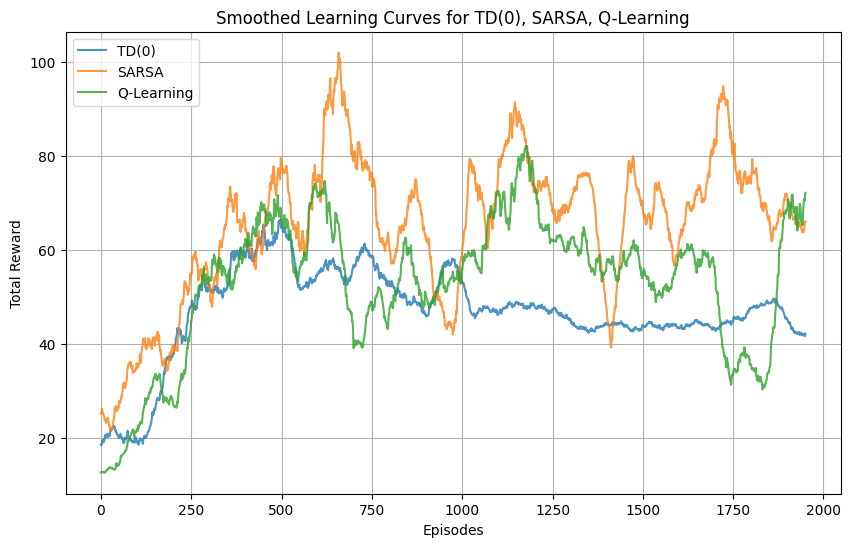

In [62]:
# Improved Plot Function
def plot_learning_curves(td_rewards, sarsa_rewards, q_rewards):
    plt.figure(figsize=(10, 6))

    # Apply smoothing
    plt.plot(smooth(td_rewards), label="TD(0)", alpha=0.8)
    plt.plot(smooth(sarsa_rewards), label="SARSA", alpha=0.8)
    plt.plot(smooth(q_rewards), label="Q-Learning", alpha=0.8)
    #plt.plot(smooth(dqn_rewards), label="DQN", linestyle="dashed", color="red")  # DQN in red dashed line
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Smoothed Learning Curves for TD(0), SARSA, Q-Learning")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(td_rewards, sarsa_rewards, q_rewards)